/home/hausemaster/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hausemaster/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


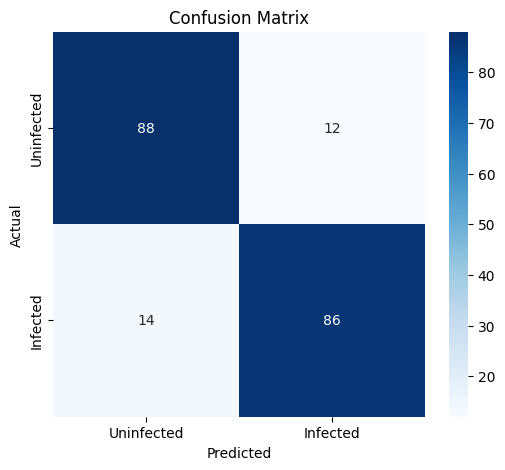


Classification Report:
Accuracy: 0.87
Precision (Uninfected): 0.86
Recall (Uninfected): 0.88
F1-Score (Uninfected): 0.87
Precision (Infected): 0.88
Recall (Infected): 0.86
F1-Score (Infected): 0.87


In [2]:
import torch
import torchvision
import cv2
import numpy as np
import xgboost as xgb
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torch import nn
from torchvision import transforms

# Define feature extraction using pre-trained ResNet50
def extract_features_resnet50(image_path):
    # Load pre-trained ResNet50 model (without the final classification layer)
    resnet = torchvision.models.resnet50(pretrained=True)
    resnet.eval()  # Set to evaluation mode
    # Remove the last fully connected layer (classification head)
    resnet = nn.Sequential(*list(resnet.children())[:-1])

    # Preprocess the image (resize, normalize, convert to tensor)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),  # Resize to the size the model expects
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        features = resnet(image_tensor)  # Get features from the penultimate layer
        features = features.view(features.size(0), -1)  # Flatten to a vector
    return features.squeeze().numpy()

# Function to load XGBoost model
def load_xgboost_model(model_path):
    model = xgb.Booster()
    model.load_model(model_path)
    return model

# Function to predict with XGBoost after feature extraction
def predict_with_xgboost(model, image_path, ground_truth_label):
    features = extract_features_resnet50(image_path)  # Extract features using ResNet50
    dmatrix = xgb.DMatrix(features.reshape(1, -1))  # Convert to DMatrix format for XGBoost
    
    # Make prediction with XGBoost
    prediction = model.predict(dmatrix)
    predicted_label = 1 if prediction > 0.5 else 0  # Threshold at 0.5 for binary classification
    predicted_label_str = "Infected" if predicted_label == 1 else "Uninfected"
    
    return ground_truth_label, predicted_label, None, predicted_label_str

# Function to evaluate all images in a folder
def evaluate_images_in_folder_xgboost(model, folder_path):
    # Lists to collect predictions and ground truth labels
    all_actual_labels = []
    all_predicted_labels = []
    
    # Process all images in the directory
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        
        if os.path.isdir(subfolder_path):
            ground_truth_label = 1 if subfolder == "infected" else 0  # Set ground truth based on folder name

            for filename in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, filename)

                actual_label, predicted_label, cam, predicted_label_str = predict_with_xgboost(
                    model, image_path, ground_truth_label
                )

                all_actual_labels.append(actual_label)
                all_predicted_labels.append(predicted_label)
    
    # Compute confusion matrix
    cm = confusion_matrix(all_actual_labels, all_predicted_labels)

    # Generate classification report
    report = classification_report(all_actual_labels, all_predicted_labels, target_names=["Uninfected", "Infected"], output_dict=True)

    # Visualize confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Uninfected", "Infected"], yticklabels=["Uninfected", "Infected"])
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(f"Accuracy: {report['accuracy']:.2f}")
    print(f"Precision (Uninfected): {report['Uninfected']['precision']:.2f}")
    print(f"Recall (Uninfected): {report['Uninfected']['recall']:.2f}")
    print(f"F1-Score (Uninfected): {report['Uninfected']['f1-score']:.2f}")
    print(f"Precision (Infected): {report['Infected']['precision']:.2f}")
    print(f"Recall (Infected): {report['Infected']['recall']:.2f}")
    print(f"F1-Score (Infected): {report['Infected']['f1-score']:.2f}")

# Main execution
if __name__ == "__main__":
    # Load the XGBoost model (make sure the path is correct)
    model_path = "xgboost_cancer_model.json"  # Path to your saved XGBoost model
    model = load_xgboost_model(model_path)

    # Folder path containing images (e.g., "test_eval/infected/" and "test_eval/uninfected/")
    folder_path = "TEST_METRICS"  # Path to the parent folder containing "infected" and "uninfected"
    
    # Evaluate all images in the folder and generate confusion matrix
    evaluate_images_in_folder_xgboost(model, folder_path)
